## Import

In [61]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, TPABC, SMCABC, SMC2ABC, SNLABC, SNL2ABC
import distributions 
import scipy.stats as stats

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem Definition

In [88]:
from problems.ABC_problems import ABC_Problem

class Gauss_Problem(ABC_Problem): #problem from Fig.4A in PLoS CB Copula paper
    
    def __init__(self, N=100, n=100):
        
        self.N = N # number of posterior samples
        self.n = n # length of the data vector x = {x_1, ..., x_n}
        self.D = 5 # dimensionality of data samples
#         self.d = 5 # dims of sufficient statistics? d=2K? This argument is just not used anywhere... great
        self.prior_args = np.array([[0,1]]) # these are bounds on theta (on X in our case: [0,1])
        
        self.K = 1 # number of thetas
        self.stat = 'raw' # raw means that sufficient statistics is unknown (I guess). y_obs = data_obs
        
#         self.data_obs = self.y_obs #important that first dim=N & y_dim = product of these dims
        
        self.is_batch_sampling_supported = False # (unfinished feature, so keep False for now) speed up rejection sampling
    
    def get_true_theta(self):
        pass # does not matter, as the result goes into 'statistics', where theta is currently not used

    def sample_from_prior(self,size=1):
        return np.random.rand(size)
    
    def simulator(self, theta):
        rho = -0.1 + (0.1+0.1)*theta #problem from Fig.4A in PLoS CB Copula paper, linearly changing rho
        samples = np.zeros((theta.size,self.n,self.D))
        for i,r in enumerate(rho):
            samples[i] = np.random.multivariate_normal(np.zeros(self.D),np.ones((self.D,self.D))*r +\
                                                np.eye(self.D)*(1-r),size=self.n)
        return samples.reshape((-1,self.D)) # [number of theta samples (normally 1) x self.n] x self.D

    # B. correlation between latent
    def _ss_corr(self, Z):
        V = np.mat(Z).T * np.mat(Z) / Z.shape[0]
        (d,d) = V.shape
        upper_tri_elements = V[np.triu_indices(d, k=1)]
        stat = np.array(upper_tri_elements)
        return stat
    
    def statistics(self, data, theta=None):
        if self.stat == 'raw':
            # (correlation) as summary statistics (all margianls are N(0,1) here, don't matter)
            stat = self._ss_corr(data)
            return stat
        else:
            raise NotImplementedError('No ground truth statistics')

In [89]:
DIR = 'results/Gauss'

problem = Gauss_Problem()
theta = problem.sample_from_prior(size=100) # sample some thetas
problem.data_obs = problem.simulator(theta) # generate 'true' observations

In [90]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:0'
hyperparams.num_sim = 1000                        # number of simulations
hyperparams.L = 5                                # number of learning rounds
hyperparams.hidden_ratio = 0.1                   # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x), use CNN here
hyperparams.estimator = 'NWJ'                    # MI estimator; JSD or DC, see the paper
hyperparams.nde = 'MDN'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)


In [ ]:
snl2_abc.run()


iteration  0
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!

[sampling] finished sampling  10
[sampling] finished sampling  20
[sampling] finished sampling  30
[sampling] finished sampling  40

 > fitting encoder
summary statistic dim = 1 original dim = 10
architecture [10, 100, 100, 1]
validation size= 0.8
finished: t= 0 loss= 0.4512431025505066 loss val= 0.4431148171424866 time= 0.06801033020019531
finished: t= 50 loss= 0.23496423661708832 loss val= 0.23178434371948242 time= 0.05666184425354004
finished: t= 100 loss= 0.0321354866027832 loss val= 0.030360519886016846 time= 0.05690574645996094
finished: t= 150 loss= 0.0012177228927612305 loss val= 0.0010892152786254883 time= 0.058159828186035156
finished: t= 200 loss= 0.00012099742889404297 loss val= 0.00016957521438598633 time= 0.05959892272949219
finished: t= 250 loss= -0.0002522468566894531 loss val= -9.989738464355469e-05 time= 0.058319807052612305
finished: t= 300 

finished: t= 150 loss= -0.002224862575531006 loss val= -0.002016305923461914 time= 0.08416867256164551
finished: t= 200 loss= -0.005363106727600098 loss val= -0.0048296451568603516 time= 0.0814894437789917
finished: t= 250 loss= -0.010997891426086426 loss val= -0.008672118186950684 time= 0.0850914716720581
finished: t= 300 loss= -0.02395397424697876 loss val= -0.021562278270721436 time= 0.08448505401611328
finished: t= 350 loss= -0.06310147047042847 loss val= -0.05587661266326904 time= 0.08506786823272705
finished: t= 400 loss= -0.14949029684066772 loss val= -0.12987226247787476 time= 0.08125793933868408
finished: t= 450 loss= -0.2588040232658386 loss val= -0.2288362979888916 time= 0.0869894027709961
finished: t= 500 loss= -0.3028631806373596 loss val= -0.2749411463737488 time= 0.0777961015701294
finished: t= 550 loss= -0.4019509553909302 loss val= -0.28867441415786743 time= 0.08203208446502686
finished: t= 600 loss= -0.37573695182800293 loss val= -0.29481446743011475 time= 0.077151656

finished: t= 2600 loss= -0.5245935916900635 loss val= -0.4061705470085144 time= 0.07843359311421712
finished: t= 2650 loss= -0.5443696975708008 loss val= -0.39917945861816406 time= 0.0763412316640218
finished: t= 2700 loss= -0.514560341835022 loss val= -0.3953237533569336 time= 0.07272505760192871
finished: t= 2750 loss= -0.46671736240386963 loss val= -0.4009997844696045 time= 0.07854596773783366
best val loss= -0.42073941230773926

 > fitting nde
all_stats.size() torch.Size([800, 1])
finished: t= 0 loss= 8.653718948364258 loss val= 8.759210586547852
finished: t= 250 loss= 1.2972582578659058 loss val= 1.2583656311035156
finished: t= 500 loss= 0.898655891418457 loss val= 0.8384626507759094
best val loss= 0.8365119099617004

 > fitting proposal
mu= [[0.5581055]]
cov= [[0.02306068]]


iteration  4
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start!

[ABC] sub-process start![ABC] sub-process start!

[sampling] finished sampling  10
[sampling] finished sampling  20
[sampling] fi

(array([  4.,  17.,  73., 195., 256., 245., 155.,  45.,   9.,   1.]),
 array([0.2288048 , 0.29247159, 0.35613838, 0.41980518, 0.48347197,
        0.54713877, 0.61080556, 0.67447235, 0.73813915, 0.80180594,
        0.86547273]),
 <a list of 10 Patch objects>)

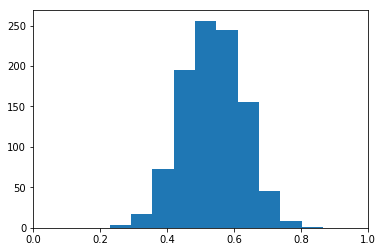

In [84]:
# let us check that the prior did not collapse 
theta = np.empty(1000)
for i in range(len(theta)): 
    theta[i] = snl2_abc.prior()
plt.xlim([0,1])
plt.hist(theta)

In [116]:
# calculate MI using all generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[0:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[0:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

torch.Size([1000, 1])


tensor(0.4097, grad_fn=<SubBackward0>)

In [117]:
# calculate MI using the last generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[snl2_abc.l:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[snl2_abc.l:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

torch.Size([200, 1])


tensor(0.2970, grad_fn=<SubBackward0>)

In [87]:
# see Fig.4A in PLoS CB paper for correct answers. Should be roughly 1 bit for 10 dims (D), 0.7 bits for 5 dims
# DV looks alright! 
# DC just always returns 0.9something, whatever the data

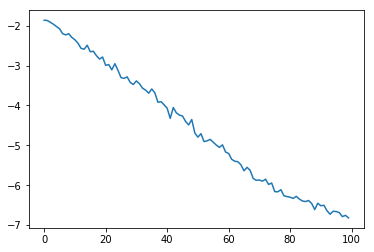

In [113]:
# visualize latents s(x)
nbins=100
stats2plot = []
data2plot = []
summary2plot = []
for i in range(nbins):
    theta = np.repeat(i/(nbins-1),100) #100 simulations
    generated = snl2_abc.problem.simulator(theta)
    get_stat = snl2_abc.convert_stat(snl2_abc.problem.statistics(generated))
    stats2plot.append(get_stat)
    data2plot.append(generated.mean(0))
    summary2plot.append(snl2_abc.problem.statistics(generated))
    
plt.plot(np.array(stats2plot).squeeze())
# np.array(stats2plot).shape
# from sklearn.manifold import TSNE, SpectralEmbedding
# from sklearn.decomposition import PCA
# latent_PCA = PCA(n_components=2).fit_transform(np.array(stats2plot).reshape(-1,1))
# latent_TSNE = TSNE(n_components=2).fit_transform(np.array(stats2plot).squeeze())
# latent_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(stats2plot).squeeze())


summary_PCA = PCA(n_components=2).fit_transform(np.array(summary2plot).squeeze())
summary_TSNE = TSNE(n_components=2).fit_transform(np.array(summary2plot).squeeze())
summary_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(summary2plot).squeeze())


data_PCA = PCA(n_components=2).fit_transform(np.array(data2plot).squeeze())
data_TSNE = TSNE(n_components=2).fit_transform(np.array(data2plot).squeeze())
data_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(data2plot).squeeze())




Text(0.32,0.26,'Binned data')

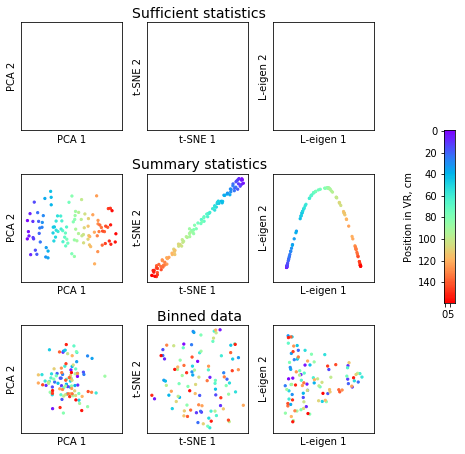

In [115]:
import matplotlib.cm as cm
fig = plt.figure(figsize=(7,6))

# fig.add_axes([0,0,1,1])


ax = [fig.add_axes([0.05,0,0.2,0.25]),
      fig.add_axes([0.3,0,0.2,0.25]),
      fig.add_axes([0.55,0,0.2,0.25]),
     fig.add_axes([0.05,0.35,0.2,0.25]),
     fig.add_axes([0.3,0.35,0.2,0.25]),
      fig.add_axes([0.55,0.35,0.2,0.25]),
     fig.add_axes([0.05,0.7,0.2,0.25]),
     fig.add_axes([0.3,0.7,0.2,0.25]),
      fig.add_axes([0.55,0.7,0.2,0.25]),
     fig.add_axes([0.85,0.3,0.1,0.4]),]

ax[0].scatter(*data_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[1].scatter(*data_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[2].scatter(*data_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

ax[3].scatter(*summary_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[4].scatter(*summary_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[5].scatter(*summary_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

# ax[6].scatter(*latent_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
# ax[7].scatter(*latent_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
# ax[8].scatter(*latent_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

for a in [ax[0],ax[3],ax[6]]:
    a.set_xlabel('PCA 1')
    a.set_ylabel('PCA 2')
    
for a in [ax[1],ax[4],ax[7]]:
    a.set_xlabel('t-SNE 1')
    a.set_ylabel('t-SNE 2')
    
for a in [ax[2],ax[5],ax[8]]:
    a.set_xlabel('L-eigen 1')
    a.set_ylabel('L-eigen 2')
    
for a in ax[:-1]:
    a.set_xticks([])
    a.set_yticks([])
    
ax[9].imshow(np.repeat(np.linspace(0,1,160).reshape(1,-1),10,axis=0).T,cmap=cm.rainbow)
ax[9].set_ylabel("Position in VR, cm")

fig.text(0.27,0.96,'Sufficient statistics',fontsize=14)
fig.text(0.27,0.61,'Summary statistics',fontsize=14)
fig.text(0.32,0.26,'Binned data',fontsize=14)

# help(plt.imshow)
# plt.scatter(*X_embedded[int(nbins*20/160):int(nbins*60/160)].T,marker='x',color='k') #late part of the corridor marked